# Classification of movie reviews with SimpleRNN and LSTM

In previous notebooks (`1_classify_movie_reviews` and `9_embeddings_movie_reviews`) we classified movie reviews using standard feed-forward neural networks. So far three approaches have been compared, and their performance on the validation set summarizes as follows:
    - Standard feed-forward NN with one-hot encoding of words [full length reviews]: 88%,
    - Standard feed-forward NN with learned word embeddings [500 word review length]: 87%,
    - Standard feed-forward NN with GloVe word embeddings [500 word review length]: 56%.
Since standard neural nets aren't able to capture the meaning of word sequences, such as the "not good" 2-gram, I assume that applying a recurrent neural network (RNN) model to the problem could result in better performance. This notebook applies two such models on the same IMDB data: a SimpleRNN model, and a more advanced Long Short Term Memory (LSTM) model. Results are then compared with the standard neural networks.

In [1]:
MAX_FEATURES = 10000
MAX_REVIEW_LENGTH = 500

We can reuse some of the following methods from previous notebooks (in general `9_embeddings_movie_reviews.ipynb).

In [2]:
def prepare_data():
    """
    Loads imdb data and splits it into train / val / test sets.
    """
    
    from keras import preprocessing
    from keras.datasets import imdb
    
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)
    print("Number of training samples:", len(x_train))

    x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_REVIEW_LENGTH)
    x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=MAX_REVIEW_LENGTH)

    # Split a part of the training dataset for validation
    x_val = x_train[:10000]
    y_val = y_train[:10000]
    x_train = x_train[10000:]
    y_train = y_train[10000:]

    print("x_train.shape:", x_train.shape)
    print("x_val.shape:", x_val.shape)
    print("x_test.shape:", x_test.shape)
    
    return ((x_train, y_train), (x_val, y_val), (x_test, y_test))


def plot_history(history, review_length = 100):
    """
    Plots the history of a model training - its loss and accuracy.
    """
    
    import matplotlib.pyplot as plt
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy [review length: %d]' % review_length)
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss [review length: %d]' % review_length)
    plt.legend()
    plt.show()

In [3]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_data()

C:\Users\mp3213\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Number of training samples: 25000
x_train.shape: (15000, 500)
x_val.shape: (10000, 500)
x_test.shape: (25000, 500)


In [4]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## SimpleRNN model

The SimpleRNN class in Keras is the most basic RNN model out there. Words of each movie review are feeded one-by-one in the model and the output of each step is feeded into the next step, so as to forward-propagate some information computed earlier in a sentence, towards the back of the sentence. Within each step, the model works pretty much as a standard neural network. 

In [6]:
def create_train_simplernn_model():
    from keras.models import Sequential
    from keras.layers import Dense, Embedding, SimpleRNN

    model = Sequential()
    model.add(Embedding(MAX_FEATURES, 32))
    model.add(SimpleRNN(32))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(x_train, y_train,
                       epochs=10,
                       batch_size=128,
                       validation_data=(x_val, y_val))
    return model, history

We can reuse the same plotting method as of earlier notebooks..

In [7]:
model, history = create_train_simplernn_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 16s 1ms/step - loss: 0.6761 - acc: 0.5638 - val_loss: 0.6796 - val_acc: 0.5521
Epoch 2/10
15000/15000 [==============================] - 14s 951us/step - loss: 0.4763 - acc: 0.7840 - val_loss: 0.5452 - val_acc: 0.7205
Epoch 3/10
 6400/15000 [===========>..................] - ETA: 6s - loss: 

KeyboardInterrupt: 

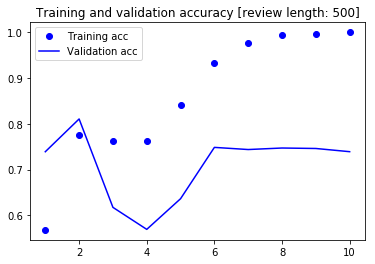

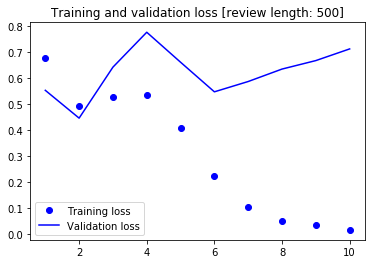

In [11]:
plot_history(history, review_length=500)

The validation accuracy tops 81%, then starting at around epoch 7, the network overfits to the training data. Well this model doesn't show any improvement, is more complex and takes longer to train. Anyway the SimpleRNN is prone to gradient vanishing / exploding so that might be one reason for the poor performance (compared to a standard NN).

## LSTM model

An improvement to the SimpleRNN is definitely the LSTM model, or a Gated Recurrent Unit GRU). These two models solve the vahishing / exploding gradient problem and are the state-of-the-art at the moment for sequence data. Let's apply the LSTM in the following.

In [4]:
def create_train_lstm_model():
    from keras.models import Sequential
    from keras.layers import Dense, Embedding, LSTM
    
    model = Sequential()
    model.add(Embedding(MAX_FEATURES, 32))
    model.add(LSTM(32))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))

    return model, history

In [5]:
model, history = create_train_lstm_model()

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 48s 3ms/step - loss: 0.5823 - acc: 0.6940 - val_loss: 0.4356 - val_acc: 0.8051
Epoch 2/10
15000/15000 [==============================] - 46s 3ms/step - loss: 0.2997 - acc: 0.8814 - val_loss: 0.3207 - val_acc: 0.8657
Epoch 3/10
15000/15000 [==============================] - 46s 3ms/step - loss: 0.1980 - acc: 0.9275 - val_loss: 0.3045 - val_acc: 0.8786
Epoch 4/10
15000/15000 [==============================] - 46s 3ms/step - loss: 0.1344 - acc: 0.9568 - val_loss: 0.3244 - val_acc: 0.8695
Epoch 5/10
15000/15000 [==============================] - 47s 3ms/step - loss: 0.0999 - acc: 0.9687 - val_loss: 0.3734 - val_acc: 0.8608
Epoch 6/10
15000/15000 [==============================] - 47s 3ms/step - loss: 0.0978 - acc: 0.9675 - val_loss: 0.3802 - val_acc: 0.8628
Epoch 7/10
15000/15000 [==============================] - 46s 3ms/step - loss: 0.0646 - acc: 0.9817 - val_loss: 0.4949 - val_acc

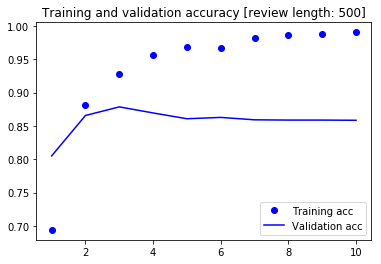

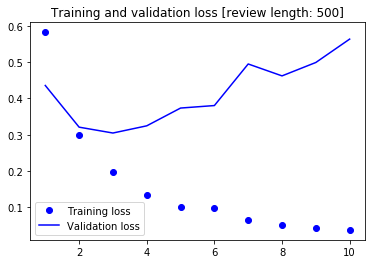

In [8]:
plot_history(history, review_length=500)

Well the LSTM model managed to reach the same performance as the standard feed-forward neural network with one-hot encoding of words. But why it didn't do better? The biggest reason seems to be that the sentiment analysis is not that suitable application for the recurrent models. A simple model of just looking at the word frequencies (or even better n-gram frequencies) could perform much better. Another reason is probably that we didn't use any regularization, which could have a small improvement. 

The SimpleRNN and LSTM models are designed to fit to sequence data, such as text in this example. Of course there are many use cases for them. Actually, any data that comes from a timeseries could be sequence data. Other, more advanced approaches that could be applied to sequence data include: bidirectional recurrent networks, or simply stacked recurrent layers. 

## References
- "Deep Learning with Python" book by Francois Chollet